In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import my_models as my_models
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [53]:
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path, data_length2):
        # load the csv file as a dataframe
        df = pd.read_csv(path, index_col=None)
        df = df[['ped1_x', 'ped1_y', 'goal_x', 'goal_y', 'd_w1', 'n_w_x1', 'n_w_y1', 'd_w2', 'n_w_x2', 'n_w_y2', 'd_w3', 
             'n_w_x3', 'n_w_y3', 'd_w4','n_w_x4', 'n_w_y4', 'd_w5','n_w_x5', 'n_w_y5', 'd_w6', 'n_w_x6', 'n_w_y6','d_w7', 
             'n_w_x7', 'n_w_y7', 'd_w8','n_w_x8', 'n_w_y8', 'd_w9','n_w_x9', 'n_w_y9', 
             'd_w_bound', 'n_w_bound_x', 'n_w_bound_y', 'rotation_angle', 'eta_group_x', 'eta_group_y', 
             'bound_x', 'bound_y', 'n1_x', 'n1_y', 'n2_x', 'n2_y', 'n3_x', 'n3_y',
             'n4_x', 'n4_y', 'n5_x', 'n5_y', 'n6_x', 'n6_y', 'n7_x', 'n7_y', 'n8_x',
             'n8_y', 'n9_x', 'n9_y', 'n1_repulse_x', 'n1_repulse_y', 'n2_repulse_x', 
             'n2_repulse_y', 'n3_repulse_x', 'n3_repulse_y', 'n4_repulse_x', 
             'n4_repulse_y', 'n5_repulse_x', 'n5_repulse_y', 'n6_repulse_x', 
             'n6_repulse_y', 'n7_repulse_x', 'n7_repulse_y', 'n8_repulse_x', 
             'n8_repulse_y', 'n9_repulse_x', 'n9_repulse_y', 'attract_x', 
             'attract_y', 'repulse_total_x', 'repulse_total_y', 'repulse_bound_x', 
             'repulse_bound_y', 'total_x', 'total_y', 'group_x', 'group_y', 'centroid_dist']]
        # process input and outputs
        temp_input = df.values[:, :2].astype('float32')
        temp_input2 = []

        for x in range(0, data_length2, 1):

            temp_input3 = temp_input[x:(10+x)] - temp_input[x]
            for z in range(len(temp_input3)):
                temp_input2.append(temp_input3[z])
        temp_input2 = np.array(temp_input2)
        temp_input2 = temp_input2.reshape(data_length2, 20)
        
        for p in df.columns[2:37]:
            if 'd_w' in p:
                temp_column = np.exp(np.reshape(np.array(df[p][9:], dtype='float32'), (data_length2, 1)))
            else: 
                temp_column = np.reshape(np.array(df[p][9:], dtype='float32'), (data_length2, 1))
            temp_input2 = np.concatenate((temp_input2, temp_column), axis=1)
        
        print(np.shape(temp_input2))

        temp_out = np.array(df[['total_x', 'total_y']], dtype="float32")
        temp_out = temp_out[9:]
        
        # store the inputs and outputs 
        self.X = temp_input2
        self.y = temp_out
        # ensure target has the right shape
        self.y = self.y.reshape((len(self.y), 2))
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.5):
        # determine sizes
        test_size_temp = round(n_test * len(self.X))
        train_size = len(self.X) - test_size_temp
        dev_size = round(.5 * test_size_temp)
        test_size = test_size_temp - dev_size
        # calculate the split
        print(train_size, dev_size, test_size)
        return data_utils.dataset.random_split(self, [train_size, dev_size, test_size])

In [36]:
# net3 complete/Final

class Net3_complete(nn.Module):
    # only attract and ped repulse here. boundary repulse can be easily added
    def __init__(self, model_attract, model_repulse, model_ped, model_group):
        super().__init__()
        self.model_attract = model_attract
        self.model_repulse = model_repulse
        self.model_ped = model_ped
        self.model_group = model_group
        
        self.combiner1 = nn.Linear(8, 20)
        self.combiner2 = nn.Linear(20, 2)       

    def forward(self, e, x_attract1, x_attract2, x_bound, x1, x2, x3, x4, x5, x6, x7, x8, x9, x_angle, x_centroid):
        head1 = self.model_attract(x_attract1, x_attract2, e)
        head2 = self.model_repulse(x_bound)
        head3 = self.model_ped(e, x1, x2, x3, x4, x5, x6, x7, x8, x9)
        temp_v_desired = e * 0.5
        temp_group = torch.cat((temp_v_desired, x_angle), 1)
        head4 = self.model_group(temp_group, x_centroid)
        # x3 = (e^dw1, nw_x1, nw_y1)
        
        combiner_input = torch.cat((head1, head2, head3, head4), 1)
        
        x = torch.relu(self.combiner1(combiner_input))
        x = self.combiner2(x)
        print(type(x))
        
        return x


In [9]:
# prepare the dataset
def prepare_data(path, data_length3):
    # load the dataset
    dataset = CSVDataset(path, data_length3)
    # calculate split
    train, dev, test = dataset.get_splits()
    # prepare data loaders
    train_dl = data_utils.DataLoader(train, batch_size=16, shuffle=True)
    dev_dl = data_utils.DataLoader(dev, batch_size=16, shuffle=True)
    test_dl = data_utils.DataLoader(test, batch_size=16, shuffle=False)
    return train_dl, dev_dl, test_dl

In [10]:
def speed_finder(positions):
    positions = positions.view((10, 2))
    temp_array = []
    for k in reversed(range(10)):
        temp_positions = positions[k] - positions[k - 1]
        temp_positions = torch.norm(temp_positions)
        temp_array.insert(0, temp_positions)
    return torch.Tensor(temp_array)

In [22]:
# evaluate the model

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        # [0, 19] == trajectories, [20, 21] == [e_x, e_y] ,[22, 23, 24] == [dw1, nw_x1, nw_y1], 
        # [25, 26, 27] == [dw2, nw_x2, nw_y2], [28, 29, 30] == [dw3, nw_x3, nw_y3], [31, 32, 33] == [dw4, nw_x4, nw_y4]
        # [34, 35, 36] == [dw5, nw_x5, nw_y5], [37, 38, 39] == [dw6, nw_x6, nw_y6], [40, 41, 42] == [dw7, nw_x7, nw_y7]
        # [43, 44, 45] == [dw8, nw_x8, nw_y8], [46, 47, 48] == [dw9, nw_x9, nw_y9]
        # [49, 50, 51] == [dw_b, nw_x_b, nw_y_b], [52, 53] == [centroid, angle]
        #  e, x_attract1, x_attract2, x_bound, x1, x2, x3, x4, x5, x6, x7, x8, x9, x_group, x_speed
        
        x_attract2 = inputs[:, :20]
        x_attract1 = []
        goal2 = inputs[:, 20:22]
        
        for p in range(len(inputs)):
            temp_x1 = speed_finder(x_attract2[p])
            x_attract1.append(temp_x1.tolist())
        x_attract1 = torch.Tensor(x_attract1)
        
        goal2 = inputs[:, 20:22]
        x1 = inputs[:, 22:25]
        x2 = inputs[:, 25:28]
        x3 = inputs[:, 28:31]
        x4 = inputs[:, 31:34]
        x5 = inputs[:, 34:37]
        x6 = inputs[:, 37:40]
        x7 = inputs[:, 40:43]
        x8 = inputs[:, 43:46]
        x9 = inputs[:, 46:49]
        x_bound = inputs[:, 49:52]
        x_angle = inputs[:, 52:53]
        x_centroid = inputs[:, 53:]
        
        yhat = model(goal2, x_attract1, x_attract2, x_bound, x1, x2, x3, x4, x5, x6, x7, x8, x9, x_angle, x_centroid)
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 2))
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    return mse

In [54]:
data_path_final = "data/ped_group_data_final_1000_group_fixed.csv"
df_n = pd.read_csv(data_path_final, index_col=None)
temp_input = np.array(df_n[["ped1_x", "ped1_y"]], dtype='float32')
data_length = len(temp_input) - 9

In [55]:
train_dl, dev_dl, test_dl = prepare_data(data_path_final, data_length)

(1219391, 55)
609695 304848 304848


In [17]:
net3_ped1 = my_models.Net3_ped1()
net3_ped2 = my_models.Net3_ped2()
net3_ped3 = my_models.Net3_ped3()
net3_ped4 = my_models.Net3_ped4()
net3_ped5 = my_models.Net3_ped5()
net3_ped6 = my_models.Net3_ped6()
net3_ped7 = my_models.Net3_ped7()
net3_ped8 = my_models.Net3_ped8()
net3_ped9 = my_models.Net3_ped9()

net3_ped_repulse_total = my_models.Net3_ped_repulse_total(net3_ped1, net3_ped2, net3_ped3, net3_ped4, net3_ped5,
                                                          net3_ped6, net3_ped7, net3_ped8, net3_ped9)

net3_attract = my_models.Net3_attract()
net3_repulse = my_models.Net3_repulse()
net3_ped_group = my_models.Net3_ped_group()

In [18]:
path_ped_repulse = "weights/Net3_ped_repulse_total.pth"
path_attract = "weights/net3_attract.pth"
path_repulse = "weights/net3_repulse.pth"
path_group = "weights/net3_ped_group.pth"

In [19]:
net3_ped_repulse_total.load_state_dict(torch.load(path_ped_repulse))
net3_attract.load_state_dict(torch.load(path_attract))
net3_repulse.load_state_dict(torch.load(path_repulse))
net3_ped_group.load_state_dict(torch.load(path_group))

<All keys matched successfully>

In [31]:
net3_complete = Net3_complete(net3_attract, net3_repulse, net3_ped_repulse_total, net3_ped_group)
# print(net3_complete)

In [23]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net3_complete.parameters(), lr=0.0001)

In [24]:
loss_array = []
x_array = []
dev_loss_array = []

In [47]:
for epoch in range(1):
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_dl):
        
        optimizer.zero_grad()
        # concatinating (0, 19) == trajectories, [20, 21] == [e_x, e_y] ,[22] = dw1 , [23, 24] == [nw_x1, nw_y1], 
        # [25] = dw2, [26, 27] == [nw_x2, nw_y2], [28] = dw3,  [29, 30] == [nw_x3, nw_y3]
        # 0:20 trajectories, 20:22 goal, 22: dw, nw
        x_attract2 = inputs[:, :20]
        x_attract1 = []
        goal2 = inputs[:, 20:22]
        
        for p in range(len(inputs)):
            temp_x1 = speed_finder(x_attract2[p])
            x_attract1.append(temp_x1.tolist())
            # goal2.append(temp_goal.tolist())
        x_attract1 = torch.Tensor(x_attract1)
        
        # [0, 19] == trajectories, [20, 21] == [e_x, e_y] ,[22, 23, 24] == [dw1, nw_x1, nw_y1], 
        # [25, 26, 27] == [dw2, nw_x2, nw_y2], [28, 29, 30] == [dw3, nw_x3, nw_y3], [31, 32, 33] == [dw4, nw_x4, nw_y4]
        # [34, 35, 36] == [dw5, nw_x5, nw_y5], [37, 38, 39] == [dw6, nw_x6, nw_y6], [40, 41, 42] == [dw7, nw_x7, nw_y7]
        # [43, 44, 45] == [dw8, nw_x8, nw_y8], [46, 47, 48] == [dw9, nw_x9, nw_y9]
        # [49, 50, 51] == [dw_b, nw_x_b, nw_y_b], [52, 53, 54] == [angle, centroid_x, centroid_y]
        # e, x_attract1, x_attract2, x_bound, x1, x2, x3, x4, x5, x6, x7, x8, x9, x_angle, x_centroid
        
        
        goal2 = inputs[:, 20:22]
        x1 = inputs[:, 22:25]
        x2 = inputs[:, 25:28]
        x3 = inputs[:, 28:31]
        x4 = inputs[:, 31:34]
        x5 = inputs[:, 34:37]
        x6 = inputs[:, 37:40]
        x7 = inputs[:, 40:43]
        x8 = inputs[:, 43:46]
        x9 = inputs[:, 46:49]
        x_bound = inputs[:, 49:52]
        x_angle = inputs[:, 52:53]
        x_centroid = inputs[:, 53:]
        
        yhat = net3_complete(goal2, x_attract1, x_attract2, x_bound, x1, x2, x3, x4, x5, x6, x7, x8, x9, x_angle, x_centroid)
        loss = loss_function(yhat, targets)
        loss.backward()
        optimizer.step()
    print("epoch no: ", epoch)
    print(loss.item())
    loss_array.append(loss.item())
    x_array.append(epoch)
    
    # evaluate dev
    mse = evaluate_model(dev_dl, net3_complete)
    dev_loss_array.append(mse)
    print('MSE_dev: %.8f, RMSE: %.4f' % (mse, np.sqrt(mse)))
    if 0.01 < loss.item() < mse :
        break

epoch no:  0
5.160378932952881
MSE_dev: 540.74316406, RMSE: 23.2539


In [ ]:
mse = evaluate_model(test_dl, net3_complete)
print('MSE_dev: %.8f, RMSE: %.4f' % (mse, np.sqrt(mse)))

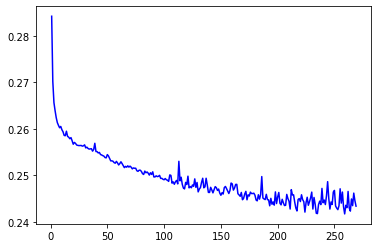

In [97]:
plt.plot(x_array[1:], dev_loss_array, color="blue")
plt.show()

In [145]:
# epoch: 200
# 0.027730274945497513
# MSE_dev: 0.28038612, RMSE: 0.5295
# torch.save(net3_complete.state_dict(), "net3_complete.pth")